In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 




In [119]:
key = random.PRNGKey(0)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([x_diff, x2_or]))
theta = jnp.array([-3, 1.5])
gamma = jnp.array([1.1, 0.2, -1, 1])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


(array([61., 60., 53., 40., 50., 64., 56., 45., 26.,  8.,  4.,  6.,  3.,
         1.,  1.,  3.,  5.,  8.,  4.,  2.]),
 array([0.        , 0.14028057, 0.28056115, 0.42084169, 0.5611223 ,
        0.70140284, 0.84168339, 0.98196399, 1.1222446 , 1.26252508,
        1.40280569, 1.54308629, 1.68336678, 1.82364738, 1.96392798,
        2.10420847, 2.24448919, 2.38476968, 2.52505016, 2.66533089,
        2.80561137]),
 <BarContainer object of 20 artists>)

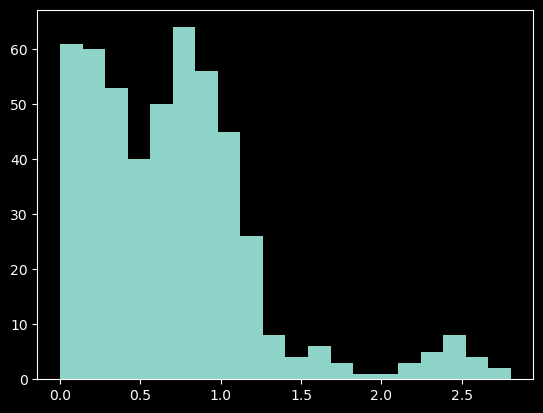

In [120]:
plt.hist(exposures, bins=20)

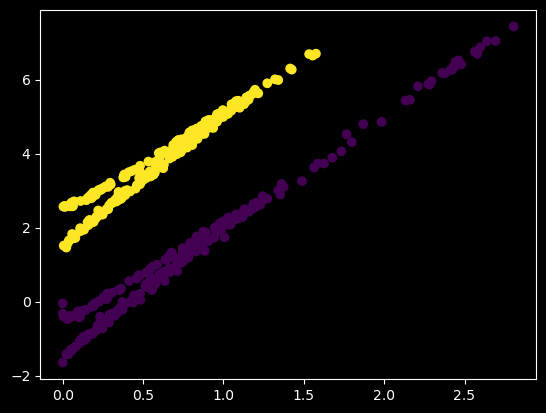

In [121]:
plt.scatter(exposures, Y, c=Z)

In [122]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [123]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-53764.203, dtype=float32), Array([-0.40488562, -2.3433218 , -0.01463171, ..., -0.39524946,
       -0.1137819 , -3.2216356 ], dtype=float32))
(Array(-54012.17, dtype=float32), Array([-248.37363, -250.31206, -247.98337, ..., -248.36398, -248.08252,
       -251.19037], dtype=float32))


(124750,) (124750,)
-54012.17 
 [ -4.3274612 -13.518629  -18.89097     0.9562459  -8.715418  -12.617494
  -8.96564   -13.198547  -16.84104  ]


(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        6.000e+00, 2.000e+00, 5.000e+00, 9.000e+00, 7.000e+00, 5.000e+00,
        6.000e+00, 5.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 1.200e+01,
        1.700e+01, 7.000e+00, 1.900e+01, 1.500e+01, 2.100e+01, 2.700e+01,
        2.500e+01, 3.000e+01, 4.100e+01, 4.300e+01, 4.900e+01, 6.500e+01,
        8.500e+01, 9.200e+01, 1.080e+02, 1.230e+02, 1.350e+02, 1.610e+02,
        1.760e+02, 1.950e+02, 2.440e+02, 2.740e+02, 2.840e+02, 3.550e+02,
        3.690e+02, 4.010e+02, 4.860e+02, 5.290e+02, 5.740e+02, 6.430e+02,
        6.570e+02, 8.010e+02, 8.450e+02, 9.280e+02, 1.048e+03, 1.090e+03,
        1.184e+03, 1.283e+03, 1.329e+03, 1.421e+03, 1.533e+03, 1.685e+03,
        1.825e+03, 1.879e+03, 2.003e+03, 2.165e+03, 2.247e+03, 2.314e+03,
        2.490e+03, 2.551e+03, 2.668e+03, 2.853e+03, 2.976e+03, 3.151e+03,
        3.108e+03, 3.297e+03, 3.454e+0

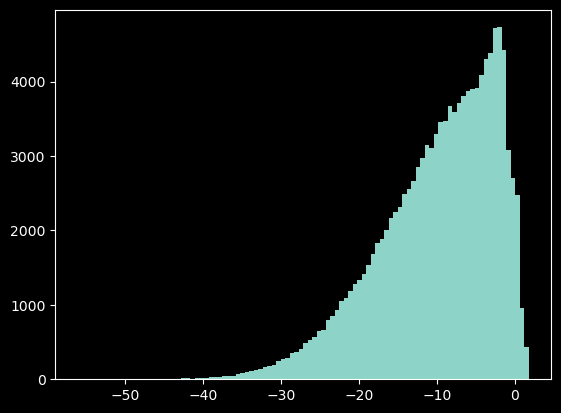

In [124]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

In [51]:
# create a function that `flip` triu_star value (0->1, 1->0), each at a time
#  and for each flip compute difference in log prob (sum)

@jax.jit
def edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx):
    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    _ ,log_prob = A_star_cond_log_post(new_triu_star[idx], triu_obs[idx], df_edges[idx,:], theta, gamma)
    return log_prob
    # return log_prob[idx]

# now wrap for all idx

@jax.jit
def flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set):
    return jnp.array([edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx) for idx in tqdm(idx_set)])

(124750,) (124750,)
flip check True
flip check 2 False
manual flip time 0.22102999687194824
(100,)


100%|██████████| 100/100 [00:00<00:00, 1946.06it/s]


func flip time 7.153838157653809
(100,)
True


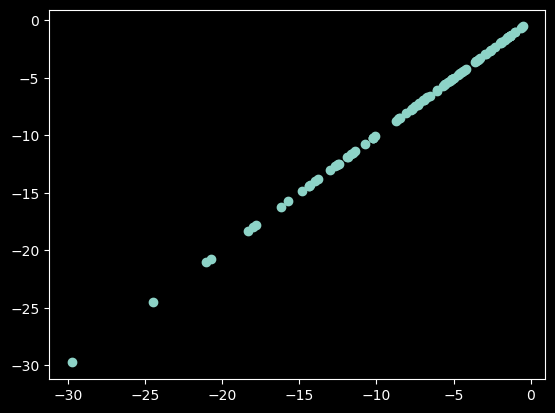

In [55]:
# samples idx_set as 100 values from triu_star

idx_set = random.choice(key, triu_dim, shape=(100,), replace=False)
# print(idx_set)

new_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])
print(triu_star.shape, new_triu_star.shape)

print("flip check", jnp.allclose(new_triu_star[idx_set], 1 - triu_star[idx_set]))
print("flip check 2", jnp.allclose(new_triu_star[idx_set],triu_star[idx_set]))


start = time.time()
_, manual_flip_loglik = A_star_cond_log_post(new_triu_star[idx_set], 
                                             triu_obs[idx_set],
                                               df_edges[idx_set,:],
                                                theta, gamma)
print("manual flip time", time.time() - start)

# manual_flip_loglik_min = manual_flip_loglik[idx_set]
print(manual_flip_loglik.shape)
# print(manual_flip_loglik_min.shape)

start = time.time()
func_flip_loglik = flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set)
print("func flip time", time.time() - start)

print(func_flip_loglik.shape)

print(jnp.allclose(manual_flip_loglik, func_flip_loglik))

plt.scatter(manual_flip_loglik, func_flip_loglik)

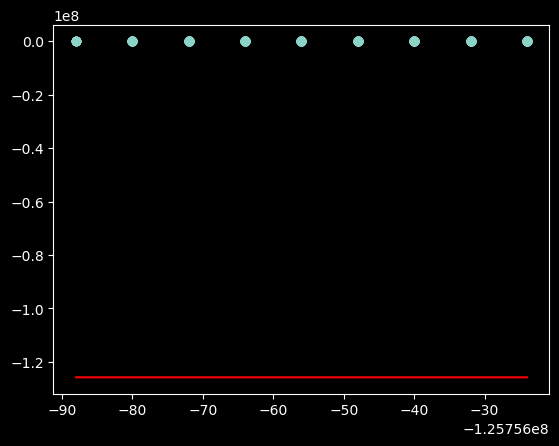

In [125]:
#  manual diff

# _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
# _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, theta, gamma)
_, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
_, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

grad_manual = f_a_tag - f_a

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

# plt.hist(score_grad, bins=100)
plt.scatter(grad_manual, score_grad)
#  add y~x line
plt.plot([min(grad_manual), max(grad_manual)], [min(grad_manual), max(grad_manual)], color='red')
# plt.hist(grad_manual - score_grad, bins=100)

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        6.000e+00, 1.100e+01, 5.000e+00, 6.000e+00, 6.000e+00, 8.000e+00,
        1.000e+01, 9.000e+00, 1.400e+01, 1.600e+01, 1.900e+01, 1.900e+01,
        1.900e+01, 3.000e+01, 3.800e+01, 3.000e+01, 4.300e+01, 6.000e+01,
        7.300e+01, 9.300e+01, 1.050e+02, 1.320e+02, 1.510e+02, 1.760e+02,
        1.940e+02, 2.110e+02, 2.890e+02, 3.070e+02, 3.720e+02, 4.180e+02,
        4.280e+02, 5.620e+02, 6.050e+02, 6.670e+02, 7.330e+02, 8.550e+02,
        9.430e+02, 1.047e+03, 1.181e+03, 1.265e+03, 1.417e+03, 1.503e+03,
        1.607e+03, 1.701e+03, 1.910e+03, 2.093e+03, 2.191e+03, 2.400e+03,
        2.529e+03, 2.621e+03, 2.842e+03, 2.929e+03, 3.150e+03, 3.307e+03,
        3.496e+03, 3.613e+03, 3.740e+03, 3.954e+03, 4.036e+03, 4.205e+03,
        4.185e+03, 4.301e+03, 4.457e+03, 4.365e+03, 4.456e+03, 4.557e+03,
        4.668e+03, 4.651e+03, 4.696e+0

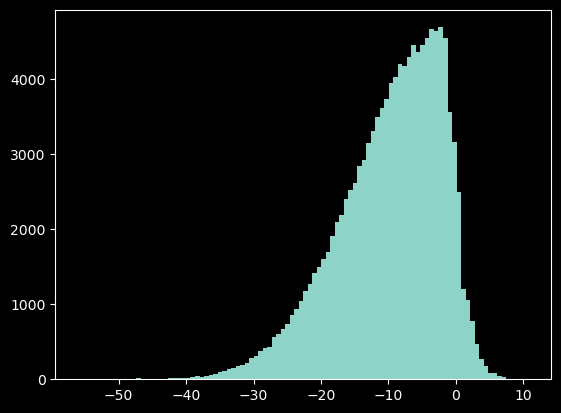

In [126]:
plt.hist(score_grad, bins=100)

In [16]:
# compare jax grad with manual grad running time by changing theta[0] values 


start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "jax grad"):
    c_theta = jnp.array([theta_0, 1.5])
    # (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma)
    (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)

print("jax time: ", time.time() - start)

start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "manual grad"):
    c_theta = np.array([theta_0, 1.5])
    _, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    _, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    # _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, c_theta, gamma)
    # _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, c_theta, gamma)
    grad_manual = f_a_tag - f_a

print("manual time: ", time.time() - start)



jax grad: 100%|██████████| 2000/2000 [00:21<00:00, 94.33it/s] 


jax time:  21.23240041732788


manual grad: 100%|██████████| 2000/2000 [00:18<00:00, 109.44it/s]

manual time:  18.275511741638184


In [10]:
print(grad_manual.shape, gradient.shape)

(124750,) (124750,)


min:  6.7267925e-13 max:  0.99546766 
 mean:  0.105714016 median:  0.013557847 
 q025:  9.975478e-07 q975:  0.6637729
min:  9.103724e-14 max:  0.96745276 
 mean:  0.025980191 median:  0.0018566202 
 q025:  1.3500353e-07 q975:  0.21084379


(array([5.8626e+04, 8.6670e+03, 5.2760e+03, 3.8300e+03, 3.1470e+03,
        2.5160e+03, 2.1760e+03, 1.9210e+03, 1.7070e+03, 1.5670e+03,
        1.5030e+03, 1.2810e+03, 1.2750e+03, 1.2530e+03, 1.1170e+03,
        1.0080e+03, 1.0490e+03, 9.6200e+02, 9.4900e+02, 8.2800e+02,
        8.7300e+02, 8.5100e+02, 8.1700e+02, 7.9000e+02, 7.4100e+02,
        7.3200e+02, 7.1000e+02, 6.6800e+02, 6.8700e+02, 6.0700e+02,
        5.8100e+02, 6.6800e+02, 6.3000e+02, 6.4400e+02, 6.1700e+02,
        5.9300e+02, 5.3100e+02, 5.1000e+02, 4.5900e+02, 3.9600e+02,
        4.0500e+02, 3.6000e+02, 3.5100e+02, 3.2100e+02, 3.4300e+02,
        3.5400e+02, 3.6300e+02, 3.7600e+02, 4.0800e+02, 4.0100e+02,
        4.5900e+02, 4.3600e+02, 4.1400e+02, 3.7100e+02, 3.6000e+02,
        2.8700e+02, 2.3700e+02, 2.1900e+02, 1.8600e+02, 1.8900e+02,
        1.8400e+02, 1.4400e+02, 1.5500e+02, 1.4100e+02, 1.4300e+02,
        1.5700e+02, 1.6900e+02, 1.4800e+02, 1.5800e+02, 1.5100e+02,
        1.5400e+02, 1.6000e+02, 1.5700e+02, 1.33

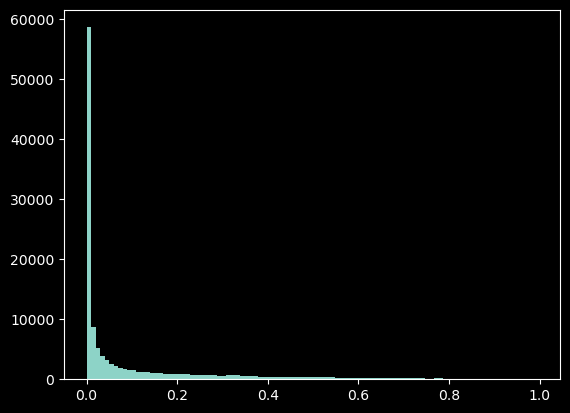

In [127]:
# grad_on_idx = (f_a_tag - f_a)/2
grad_on_idx = score_grad / 2

flip_probs = jnp.exp(grad_on_idx) / (jnp.exp(grad_on_idx) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs), "max: ", jnp.max(flip_probs), "\n",
      "mean: ", jnp.mean(flip_probs),
      "median: ", jnp.median(flip_probs), "\n",
      "q025: ", jnp.quantile(flip_probs, 0.025),
        "q975: ", jnp.quantile(flip_probs, 0.975))

flip_probs_rate = jnp.exp(grad_on_idx - 2) / (jnp.exp(grad_on_idx - 2) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs_rate), "max: ", jnp.max(flip_probs_rate), "\n",
      "mean: ", jnp.mean(flip_probs_rate),
      "median: ", jnp.median(flip_probs_rate), "\n",
      "q025: ", jnp.quantile(flip_probs_rate, 0.025),
        "q975: ", jnp.quantile(flip_probs_rate, 0.975))

plt.hist(flip_probs, bins=100)

In [110]:
# sample uniform[0,1] with dim as flip_probs_rate
# and compare with flip_probs_rate
flip_edges = random.uniform(key, shape=(triu_dim,)) < flip_probs_rate
print(flip_edges.mean(), flip_edges.sum())


0.025258515 3151


0.21046884 210.46883
0.03380498
9.357623e-14


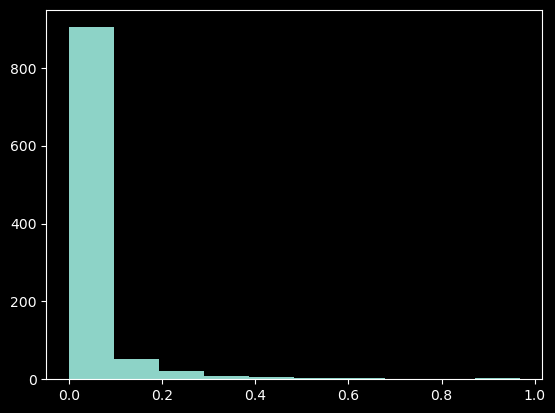

In [52]:
idxs = random.choice(key, triu_dim, shape=(1000,), replace=False)
prop_triu = triu_star.at[idxs].set(1 - triu_star[idxs])

_, tst_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
tst_grad = tst_grad[idxs]

temp_ratio = jnp.exp((-(2*triu_star[idxs]-1)*tst_grad)/2. - 2)
print(temp_ratio.mean(), temp_ratio.sum())
temp_ratio = jnp.clip(temp_ratio, -30, 30)
temp_prob = temp_ratio / (temp_ratio + 1)
print(temp_prob.mean())

plt.hist(temp_prob)

print(jnp.exp(-30) / (jnp.exp(-30) + 1))

In [145]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .005
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 100


@jax.jit
def triu_star_update(triu_star, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, key, alpha = 5, eps = 1e-10):
    
    key1, key2, key3 = random.split(key, 3)
    # batch_size = (triu_star.shape[0]*batch_prop).astype(int)
    # sample mini-batch for potential edge flip
    idx_set = random.choice(key1, TRIU_LEN, 
                            shape=(BATCH_LEN,),
                              replace=False)
    # proposed raw new triu_star with edged flipped
    # proposed_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])

    # compute \tilde{f}(A*_t)
    # _, baseline_edge_loglik = A_star_cond_log_post(triu_star[idx_set],
    #                                                 triu_obs[idx_set],
    #                                                 df_edges[idx_set,:],
    #                                                 theta, gamma)
    # # compute \tilde{f}(\tilde{A}*_t)
    # _, proposed_edge_loglik = A_star_cond_log_post(proposed_triu_star[idx_set],
    #                                                 triu_obs[idx_set],
    #                                                 df_edges[idx_set,:],
    #                                                 theta, gamma)
    # Approximate with gradient
    (_,_), baseline_edge_loglik = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
    baseline_edge_loglik = baseline_edge_loglik[idx_set]
    # print(baseline_edge_loglik.shape)
    # compute \tilde{f}(\tilde{A}*_t)
    # (_,_), proposed_edge_loglik = val_grad_fn(proposed_triu_star, triu_obs, df_edges,
    #                                         theta, gamma, Y, x, Z, eta)[idx_set]
   
    # compute g(exp(d(\tilde{A}*_t, A*_t))) for g(a) = \sqrt{a} 
    # TODO: add step size by subtracting within the exp some rate $\alpha$ (can be adaptive)
    # temp_lik_ratio = jnp.exp((proposed_edge_loglik - baseline_edge_loglik)/2. - alpha)
    temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*baseline_edge_loglik)/2. - alpha)
    temp_lik_ratio = jnp.clip(temp_lik_ratio, -30, 30)

    # compute proposal probabilities q(\tilde{A}*_t|A*_t) \propto Softmax(exp(d(\tilde{A}*_t, A*_t)/2))
    forward_flip_probs = temp_lik_ratio / (temp_lik_ratio + 1)
    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < forward_flip_probs
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = forward_flip_probs * flip_indicator + (1 - forward_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx_set].set(flip_indicator * (1 - triu_star[idx_set]) +
                                              (1 - flip_indicator) * triu_star[idx_set])

    
    # Backward proposal
    # _, new_edge_loglik = A_star_cond_log_post(new_triu_star[idx_set],
    #                                           triu_obs[idx_set],
    #                                           df_edges[idx_set,:],
    #                                           theta, gamma) 
    (_,_), new_edge_loglik = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
    new_edge_loglik = new_edge_loglik[idx_set]
    # TODO: save here for step size $\alpha$
    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2.)
    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - new_edge_loglik)/2. - alpha)
    backward_temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*new_edge_loglik)/2. - alpha)
    backward_temp_lik_ratio = jnp.clip(backward_temp_lik_ratio, -30, 30)

    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2. - alpha)
    backward_flip_probs = backward_temp_lik_ratio / (backward_temp_lik_ratio + 1)
    backward_probs = backward_flip_probs * flip_indicator + (1 - backward_flip_probs) * (1 - flip_indicator)
    backward_proposal = jnp.sum(jnp.log(backward_probs + eps))

    # compute full (f) log-posterior diff $f(A*_new) - f(A*_baseline)$
    # f_baseline, _ = A_star_cond_log_post(triu_star, triu_obs, df_edges,
    #                                              theta, gamma)
    # f_proposed, _ = A_star_cond_log_post(new_triu_star, triu_obs, df_edges,
    #                                               theta, gamma)
    f_baseline, _ = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges,
                                                 theta, gamma,
                                                 Y, X, Z, eta)
    f_proposed, _ = A_star_cond_log_post_with_Y(new_triu_star, triu_obs, df_edges,
                                                  theta, gamma,
                                                  Y, X, Z, eta)
    
#     print("forward proposal: ", forward_proposal, "\n",
#            "backward proposal: ", backward_proposal)
    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_proposal - forward_proposal),
                                a_max=1)
    # TODO: save acceptance ratio for diagnostics and adaptive step size
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # if i % 100 == 0:
    #     print("prop flipped from possible: ", flip_indicator.mean(), "; total:" , flip_indicator.sum())
    #     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    #     print("full posterior diff: ", f_proposed - f_baseline)
    #     print("reverse proposal diff", backward_proposal - forward_proposal)
#     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    return new_triu_star,forward_flip_probs.mean(), acceptance_ratio, flip_indicator.mean(), f_proposed - f_baseline, backward_proposal - forward_proposal, temp_lik_ratio.mean()
    
     

In [146]:
# make noisy triu_star

triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

# test A_star update
# triu_len = triu_star_noisy.shape[0]
# batch_prop = 0.5
# batch_len = int(triu_len * batch_prop)
# new_triu_star = triu_star_update(triu_star_noisy, triu_obs, df_edges,
#                                   theta, gamma, Y, x, Z, eta, key,
#                                    triu_len, batch_len)

n_iter = 1500
new_triu_star = triu_star_noisy
exposures_lst = [compute_exposures(new_triu_star, Z)]
for i in tqdm(range(int(n_iter))):
    key, _ = random.split(key)
    new_triu_star, fprob, acc, ind, f_p, ftild_p, b = triu_star_update(new_triu_star, triu_obs, df_edges,
                                      theta, gamma, Y, x, Z, eta, key)
    exposures_lst.append(compute_exposures(new_triu_star, Z))
    if i % 100 == 0:
        print("key: ", key)
        # print("idx_set: ", idx_set)
        print("flip prob mean: ", fprob)
        print("Acceptance rate: ", acc.mean())
        print("prop flipped from possible: ", ind)
        print("full posterior diff: ", f_p)
        print("reverse proposal diff", ftild_p)
        print("temp lik ratio mean: ", b)


  0%|          | 1/1500 [00:02<1:05:41,  2.63s/it]

key:  [1274716056  500095685]
flip prob mean:  0.10242308
Acceptance rate:  1.0
prop flipped from possible:  0.10433387
full posterior diff:  1545.6094
reverse proposal diff -1.9514561
temp lik ratio mean:  2.5569613


  7%|▋         | 101/1500 [00:12<02:17, 10.19it/s]

key:  [421687589 371282929]
flip prob mean:  0.04275785
Acceptance rate:  1.0
prop flipped from possible:  0.038523275
full posterior diff:  451.92188
reverse proposal diff -2.6173553
temp lik ratio mean:  0.88617367


 14%|█▎        | 203/1500 [00:23<02:13,  9.72it/s]

key:  [1211579825 1924595326]
flip prob mean:  0.028519608
Acceptance rate:  1.0
prop flipped from possible:  0.030497592
full posterior diff:  276.0547
reverse proposal diff -4.3524704
temp lik ratio mean:  0.5041519


 20%|██        | 302/1500 [00:33<01:59, 10.07it/s]

key:  [3172989999 2512954840]
flip prob mean:  0.018504472
Acceptance rate:  1.0
prop flipped from possible:  0.019261638
full posterior diff:  167.39844
reverse proposal diff -2.5439262
temp lik ratio mean:  0.3638845


 27%|██▋       | 402/1500 [00:43<01:47, 10.19it/s]

key:  [4160531770 2472102574]
flip prob mean:  0.015966658
Acceptance rate:  1.0
prop flipped from possible:  0.014446228
full posterior diff:  131.82812
reverse proposal diff -2.3364277
temp lik ratio mean:  0.2579466


 34%|███▎      | 503/1500 [00:54<01:39, 10.01it/s]

key:  [4200030924 3046179331]
flip prob mean:  0.0056793937
Acceptance rate:  1.0
prop flipped from possible:  0.0064205457
full posterior diff:  56.890625
reverse proposal diff -1.376082
temp lik ratio mean:  0.05794399


 40%|████      | 603/1500 [01:04<01:29, 10.00it/s]

key:  [2600368515  288589802]
flip prob mean:  0.005695322
Acceptance rate:  1.0
prop flipped from possible:  0.0032102729
full posterior diff:  28.21875
reverse proposal diff -0.25952053
temp lik ratio mean:  0.054219965


 47%|████▋     | 702/1500 [01:14<01:19, 10.08it/s]

key:  [3788292379 2731548327]
flip prob mean:  0.0032822937
Acceptance rate:  1.0
prop flipped from possible:  0.0032102729
full posterior diff:  5.6015625
reverse proposal diff -0.83546543
temp lik ratio mean:  0.004308356


 53%|█████▎    | 802/1500 [01:24<01:11,  9.70it/s]

key:  [3438168739 3005301152]
flip prob mean:  0.0035434559
Acceptance rate:  1.0
prop flipped from possible:  0.0064205457
full posterior diff:  9.402344
reverse proposal diff -1.0839119
temp lik ratio mean:  0.0038358471


 60%|██████    | 902/1500 [01:34<01:00,  9.89it/s]

key:  [1438393531 3471767946]
flip prob mean:  0.0034497248
Acceptance rate:  0.06959809
prop flipped from possible:  0.0048154094
full posterior diff:  -2.109375
reverse proposal diff -0.5556431
temp lik ratio mean:  0.004069453


 67%|██████▋   | 1002/1500 [01:44<00:48, 10.18it/s]

key:  [3420252999 2313496691]
flip prob mean:  0.0031794566
Acceptance rate:  1.0
prop flipped from possible:  0.0
full posterior diff:  0.0
reverse proposal diff 0.0
temp lik ratio mean:  0.003887909


 74%|███████▎  | 1103/1500 [01:54<00:39, 10.08it/s]

key:  [2627476694  107812903]
flip prob mean:  0.0027039303
Acceptance rate:  1.0018091e-09
prop flipped from possible:  0.0032102729
full posterior diff:  -18.550781
reverse proposal diff -2.1706772
temp lik ratio mean:  0.0030969442


 80%|████████  | 1202/1500 [02:05<00:34,  8.62it/s]

key:  [3576325157 3898157899]
flip prob mean:  0.00375728
Acceptance rate:  1.0
prop flipped from possible:  0.0032102729
full posterior diff:  28.511719
reverse proposal diff -0.13355064
temp lik ratio mean:  0.05045783


 87%|████████▋ | 1301/1500 [02:17<00:42,  4.63it/s]

key:  [1123184259 2336481882]
flip prob mean:  0.0028424542
Acceptance rate:  1.0
prop flipped from possible:  0.0016051364
full posterior diff:  1.1484375
reverse proposal diff -0.010396957
temp lik ratio mean:  0.0035668262


 93%|█████████▎| 1402/1500 [02:29<00:09,  9.87it/s]

key:  [2145765341 1535340161]
flip prob mean:  0.0030408928
Acceptance rate:  1.0
prop flipped from possible:  0.0016051364
full posterior diff:  0.65625
reverse proposal diff -0.27502728
temp lik ratio mean:  0.00352983


100%|██████████| 1500/1500 [02:39<00:00,  9.43it/s]


In [ ]:
# TODO: add adaptive step size for alpha to obtain acceptance rate (of edges flip) around 0.574 (optimal)
# TODO: see tradeoff between number BATCH_LEN and acceptance rate
# TODO: check if some terms are canceled in the final acceptance ratio due to the lack of use of the outcome model in edge propsal

(1501, 500)
0.70646095
[5.036341   4.9939923  4.9586296  ... 0.65660125 0.6570261  0.6570501 ]


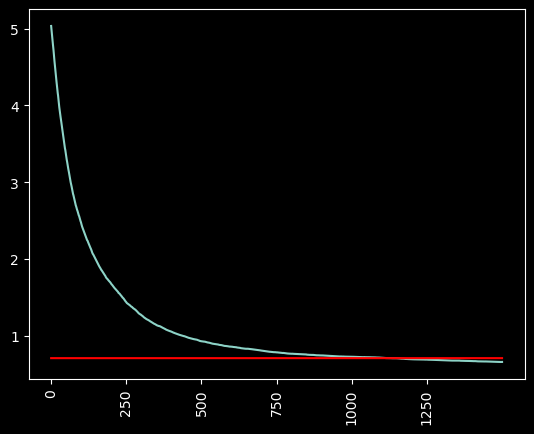

In [149]:
from sympy import rotations


expos_arr = jnp.array(exposures_lst)
print(expos_arr.shape)
print(exposures.mean())
# plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
print(expos_arr.mean(axis=1))
# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
# add x-ticks vertical with 500 step siz
plt.xticks(range(0, n_iter, 250), rotation=90) 
plt.show()

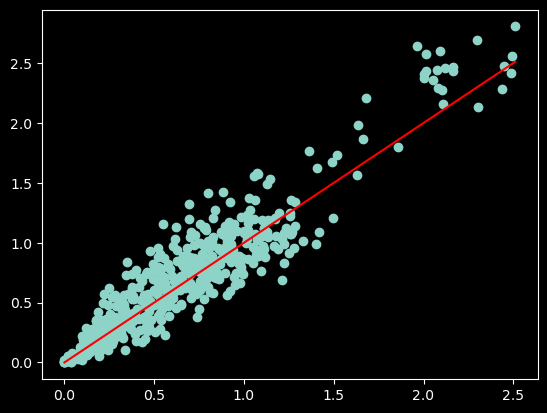

In [154]:
plt.scatter(expos_arr[-1,:], exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [150]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, triu_star_noisy))

print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == triu_star_noisy))

# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 115739 | 2421 |
   1    | 2061 | 4529 |
[[115739   2421]
 [  2061   4529]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 106548 | 11612 |
   1    | 651 | 5939 |
[[106548  11612]
 [   651   5939]]
0.9640721
0.90169936
